## **(Still) At a Crossroads With Incident Data: A DATA102 Final Project**

*By Group 1:* **Julia Patricia Estella**, **Shannon Gail Ho**, **Matthew Neal Lim**

## **Introduction**

Traffic has always been a major problem in our day to day lives. Aside from the usual traffic congestion, there is always a risk for traffic accidents. For our project, we want to investigate the issue regarding **traffic incidents** to find possible connections with other factors. For example, will certain times of the day translate to a high rate of traffic accidents?

Here's what to expect:

<ol style="list-style-type: upper-roman;">
    <li>Problem Statement</li>
    <li>Data Collection</li>
    <li>Data Preprocessing (Cleaning & Feature Engineering)</li>
    <li>Exploratory Data Analysis</li>
    <li>Modeling & Evaluation</li>
    <li>Conclusion</li>
    <li>References</li>
</ol>

## **I. Problem Statement**

Information Systems bridge organizations and tech. In IS, systems are developed to aid upper management in managing and analyzing data to make informed decisions. This field encompasses multiple industries, and so it exists for as long as there is a need to make processes more efficient and effective. With this, one possible use case of data mining is to analyze road accidents data to come up with predictions on where and when vehicle accidents could happen. This is especially relevant to the road situations here in Metro Manila.

According to Beltran (2021), "Metro Manila averaged 178 road-crash incidents per day, with 50,230 cases resulting in damage to property, and 14,465 resulting in non-fatal injury." The Metropolitan Manila Development Authority, or MMDA, has already been dealing with issues of traffic, congestion, and road accidents over the years. Having one of the highest urban densities in the world, little to no action is being done with these situations, which continuously affect the country's situation.

Moreover, most of these incidents can be avoided or reduced by anticipating the date, time, and location they occur. Using predictions on where and when road accidents could happen, MMDA can (1) reassess stoplight timers in congested roads, (2) deploy officers to the right place and time, and (3) proactively plan and broadcast alternative routes.

Additionally, a similar study has been done by Keskin et al. (2011) where they analysed the incident occurrence and correlated it to how far the incident occurred from a known area. From there, they can apply classification models. This notebook will take this in a different direction, however, because the treatment used will be that of regression instead.

### **Dataset Information: MMDA Twitter**

- The Metropolitan Manila Development Authority (MMDA) has already been dealing with issues of traffic, congestion, and road accidents over the years.
- Most of these incidents can be avoided or reduced by anticipating the date, time, and location they occur.
- Through MMDA’s Twitter account, **consistent accident alert tweets** can be found. These tweets specifically consist of **live incident updates** or alerts across **major roads in Metro Manila** such as EDSA, Roxas Boulevard, C5, etc.
- Due to Twitter's API having limitations in their output and searching, **web scraping with Selenium** will be utilized instead in order to perform infinite scrolling through all the tweets. Keywords with **"MMDA ALERT"** and **"Vehicular Accident"** will be used as filters to collect the tweets. These tweets will then be processed accordingly, depending on the type of tweet.
- Additionally, a limitation within the dataset to be recognised is the dataset itself is prone to **typographical errors** and **tweet structure inconsistencies**. These may or may not be picked up by the cleaning algorithm, and may throw some results off.
- A note: the charts, previews, and terminal logs that are currently showing below are using an older version/snapshot of the dataset. This was done so to save time in testing, by avoiding repeated scrapes. A quick import-export block of code is available at the end of the notebook.

### **Library Imports**

In [1]:
import requests
import pandas as pd
import numpy as np
import time
import re
from datetime import datetime, timedelta

from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
from selenium.common.exceptions import NoSuchElementException

import matplotlib.pyplot as plt
import seaborn as sns

For a more instantaneous searching, the search query will already be injected straight into the URL of the page in question, seen below. More specifically, the query is `"MMDA ALERT" "Vehicular Accident" (from:MMDA)`, making use of the literals `MMDA ALERT` and `Vehicular Accident` to filter results by text, and `from:MMDA` to filter by author. The other query attribute `f=live` sorts the results by most recent.

In [2]:
path = 'https://twitter.com/search?q=%22MMDA%20ALERT%22%20%22Vehicular%20Accident%22%20(from%3AMMDA)&src=typed_query&f=live'

## **II. Data Collection**

As mentioned previously, Selenium will be used to scrape Twitter's search results. We assume the results to already be regarding about new traffic incidents only by searching for the keyword `MMDA ALERT`, since the other tweets also contain updates to incidents already reported. Additionally, the collection method sets a limit on exceeding 500 tweets as an arbitrary limit. The following code will open the page, then repeatedly scrape the tweets and scroll down.

For this to be possible, a combination of hard-coded XPath values and attributes are used to "streamline" the data cleaning further down the road.

In [ ]:
tweets = []
processed = []

# gonna be using geckodriver to simulate a Firefox browser
driver = webdriver.Firefox()
driver.get(path)

# current limits are:
#### when the collected tweets exceed 500 (arbitrary limit since it can take a long time), or
#### when an exception gets encountered (see: except block)
while len(processed) < 500:
    try:
        # making use of selenium's expected conditions and action chains to wait for tweets to load...
        tweets = WebDriverWait(driver, 10).until(
            EC.presence_of_all_elements_located((By.XPATH, "//article[@data-testid='tweet']"))
        )
        
        # grab the time tag and the the whole text content of the tweet
        for twt in tweets:
            timestamp = twt.find_element_by_tag_name("time")
            processed.append({"raw_time": timestamp.get_attribute("datetime"), "text_content": twt.text})
        
        # scroll to the end of the page
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(1)
    except:
        # to be honest i still don't know how to deal with these exceptions
        print("NoSuchElement or StaleElementReference found sadly, exiting...")
        break

# let's see how many tweets we got... wow that's a lot!
print("processed tweets: ", len(processed))

In [ ]:
# let's see what one tweet deconstructed looks like!
print(processed[0])

## **III. Data Preprocessing (Cleaning & Feature Engineering)**

So the tweets have been deconstructed into its timestamp as a string and into its text content. However, they will need to be processed to better extract data from. More specifically, the features to be extracted and isolated are:

1. time and its more specific values (year, month, day, weekday, hour),
2. name of the road and particular area of the road of the accident,
3. specific direction (north, east, west, southbound),
4. vehicles involved and presence of specific vehicles (motorcycle, car, van, truck, suv), and
5. number of lanes occupied.

In [3]:
# the great mission: pre-processing
### (1) time
### (2) names of the road and particular area of the road where the accident happened
### (3) specific direction (north, east, west, south bound)
### (4) vehicles involved
### (5) number of lanes occupied

for i in processed:
    try:
        # strip and clean the tweet body first
        if len(i['text_content'].split('\n')) > 1:
            i['body'] = i['text_content'].split('\n')[4]
        else:
            i['body'] = i['text_content']
        i['body'] = i['body'].replace('  ', ' ')

        # parse string timestamp to a datetime object and other details
        i['timestamp'] = datetime.strptime(i['raw_time'], '%Y-%m-%dT%H:%M:%S.000Z')
        i['year'] = i['timestamp'].year
        i['month'] = i['timestamp'].month
        i['day'] = i['timestamp'].day
        i['weekday'] = i['timestamp'].weekday()
        i['hour'] = i['timestamp'].hour
        
        # parse the road and area from the text_content
        if len(re.findall(r"at (.+) (SB|NB|WB|EB|involving)", i['body'])) > 0:
            i['area'] = re.findall(r"at (.+) (SB|NB|WB|EB|involving)", i['body'])[0][0]
        else:
            i['area'] = None

        # parse direction from the text_content
        if len(re.findall(r"SB|NB|WB|EB", i['body'])) > 0:
            i['direction'] = re.findall(r"SB|NB|WB|EB", i['body'])[0]
        else:
            i['direction'] = None

        # parse vehicles involved
        if len(re.findall(r"involving (.+) as of", i['body'])) > 0:
            i['vehicles'] = re.findall(r"involving (.+) as of", i['body'])[0]
            if len(i['vehicles'].split(", ")) > 1 and "cleared" in i['vehicles'].split(", ")[1]:
                i['vehicles'] = i['vehicles'].split(", ")[0]
        else:
            i['vehicles'] = None
        
        ## parsing presence of different vehicles too
        i['motorcycle'] = 1 if i['vehicles'] is not None and i['vehicles'].lower().find('motorcycle') != -1 else 0
        i['car'] = 1 if i['vehicles'] is not None and i['vehicles'].lower().find('car') != -1 else 0
        i['van'] = 1 if i['vehicles'] is not None and i['vehicles'].lower().find('van') != -1 else 0
        i['truck'] = 1 if i['vehicles'] is not None and i['vehicles'].lower().find('truck') != -1 else 0
        i['suv'] = 1 if i['vehicles'] is not None and i['vehicles'].lower().find('suv') != -1 else 0

        # parse number of lanes
        if len(re.findall(r"(\d+) (lane |lanes |)occupied", i['body'])) > 0:
            i['lanes'] = re.findall(r"(\d+) (lane |lanes |)occupied", i['body'])[0][0]
        else:
            i['lanes'] = 0
    except Exception as e:
        # error handling for debugging
        print(e, i)

In [4]:
# Creating the dataframe with the column names now
df = pd.DataFrame(processed, columns=['timestamp', 'year', 'month', 'day', 'weekday', 'hour', 'area', 'vehicles', 'motorcycle', 'car', 'van', 'truck', 'suv', 'direction', 'lanes'])

# Get the shape and also a preview of the dataframe itself
df

,timestamp,year,month,day,weekday,hour,area,vehicles,motorcycle,car,van,truck,suv,direction,lanes
0,2022-02-12 08:53:07,2022,2,12,5,8,Commonwealth Tandang Sora EB,taxi and motorcycle,1,0,0,0,0,EB,1
1,2022-02-12 08:24:29,2022,2,12,5,8,Edsa Ayala tunnel,car and AUV at Edsa Ayala tunnel SB,0,1,0,0,0,SB,1
2,2022-02-12 04:30:44,2022,2,12,5,4,EDSA Monte de Piedad SB,motorcycle and taxi,1,0,0,0,0,SB,1
3,2022-02-12 04:09:31,2022,2,12,5,4,Aurora Katipunan WB,motorcycle and van,1,0,1,0,0,WB,1
4,2022-02-12 02:00:45,2022,2,12,5,2,EDSA Trinoma NB,closed van,0,0,1,0,0,NB,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,2022-01-05 00:23:09,2022,1,5,2,0,C5 Libis tunnel SB,motorcycle and car,1,1,0,0,0,SB,1
512,2022-01-04 23:19:32,2022,1,4,1,23,Marcos Highway Marcos bridge WB,motorcycle,1,0,0,0,0,WB,1
513,2022-01-04 23:00:10,2022,1,4,1,23,C5 Kalayaan SB,car and motorcycle,1,1,0,0,0,SB,1
514,2022-01-04 21:02:38,2022,1,4,1,21,Quezon Avenue Tunnel EB before Agham Road,Tanker and Car,0,1,0,0,0,EB,0


In [5]:
# summaries of time mapping
# number still included on the data for sorting purposes in the charts

# mapping the weekday number into its lexical counterpart
weekday_map = {
    0: '0 Monday',
    1: '1 Tuesday',
    2: '2 Wednesday',
    3: '3 Thursday',
    4: '4 Friday',
    5: '5 Saturday',
    6: '6 Sunday'
}
df['weekday'] = df['weekday'].replace(weekday_map)

# mapping the month number into its lexical counterpart
month_map = {
    1: '1 January',
    2: '2 February',
    3: '3 March',
    4: '4 April',
    5: '5 May',
    6: '6 June',
    7: '7 July',
    8: '8 August',
    9: '9 September',
    10: '10 October',
    11: '11 November',
    12: '12 December'
}
df['month'] = df['month'].replace(month_map)

## **IV. Exploratory Data Analysis**

Now that we have our data, we also want to see the contents at an overview. So, let's do some dissection on the different features to see summaries of them. For this one, analyses will be done over **hour, weekday, and area**.

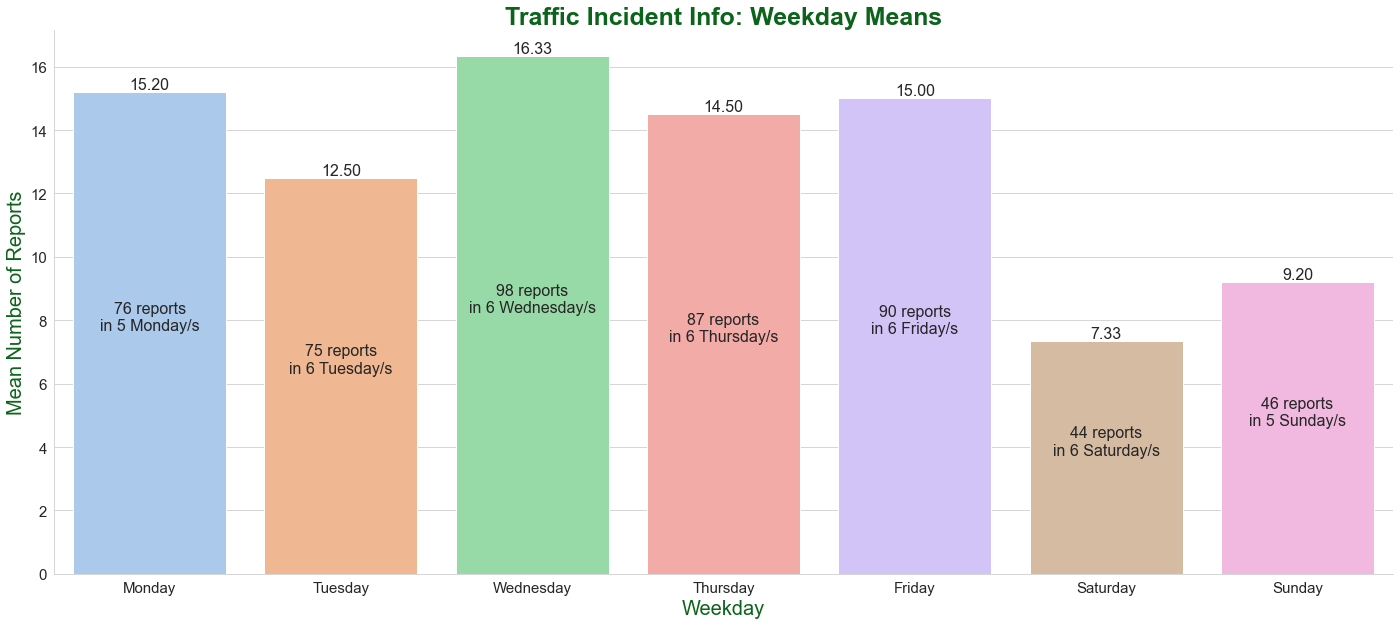

In [6]:
# group by on weekday, then extract the counts and means as well
day_counts = df.groupby('weekday').size().reset_index().rename(columns = {0: 'count'})
day_counts_agg = df.groupby(['year', 'month', 'day', 'weekday']).size().reset_index().rename(columns = {0: 'count'})
day_counts_agg = day_counts_agg.groupby(['weekday']).size().reset_index().rename(columns = {0: 'count'})
day_counts['mean'] = day_counts['count'] / day_counts_agg['count']

sns.set_palette(sns.color_palette('pastel'))
sns.set_context({'figure.figsize': (24, 10)})
sns.set_style('whitegrid')

# Plotting the chart
ax = sns.barplot(x='weekday', y='mean', data=day_counts)

# Setting the chart
ax.set_title('Traffic Incident Info: Weekday Means', color='#0c641b', fontweight='bold', fontsize=25)
ax.set_xlabel('Weekday', color='#0c641b', fontsize=20)
ax.set_ylabel('Mean Number of Reports', color='#0c641b', fontsize=20)
ax.tick_params(labelsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels([i.get_text().split(' ')[1] for i in ax.get_xticklabels()])

# configuring the column labels
for r, l, w_c, w in zip(ax.patches, day_counts['count'], day_counts_agg['count'], day_counts_agg['weekday']):
    height = r.get_height()
    ax.text(r.get_x() + r.get_width() / 2, height / 2, str(l) + ' reports\nin ' + str(w_c) + ' ' + str(w).split(' ')[1] + '/s', fontsize=16, ha="center", va="bottom")
    ax.text(r.get_x() + r.get_width() / 2, height, f'{l / w_c:.2f}', fontsize=16, ha="center", va="bottom")

plt.show()

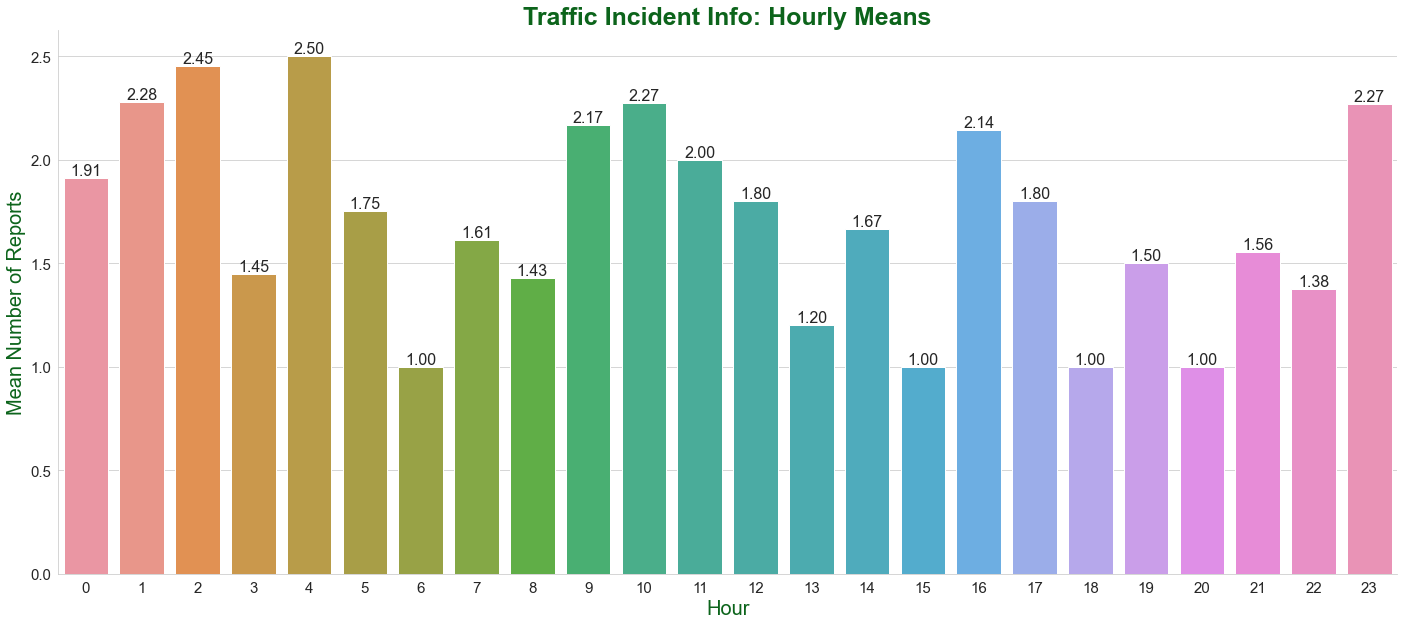

In [7]:
# group by on hour, then extract the counts and means as well
hourly_counts = df.groupby('hour').size().reset_index().rename(columns = {0: 'count'})
hourly_counts_agg = df.groupby(['year', 'month', 'day', 'hour']).size().reset_index().rename(columns = {0: 'count'})
hourly_counts_agg = hourly_counts_agg.groupby(['hour']).size().reset_index().rename(columns = {0: 'count'})
hourly_counts['mean'] = hourly_counts['count'] / hourly_counts_agg['count']

sns.set_palette(sns.color_palette('tab10'))
sns.set_context({'figure.figsize': (24,10)})
sns.set_style('whitegrid')

# Plotting the chart
ax = sns.barplot(x='hour', y='mean', data=hourly_counts)

# Setting the chart
ax.set_title('Traffic Incident Info: Hourly Means', color='#0c641b', fontweight='bold', fontsize=25)
ax.set_xlabel('Hour', color='#0c641b', fontsize=20)
ax.set_ylabel('Mean Number of Reports', color='#0c641b', fontsize=20)
ax.tick_params(labelsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# configuring the column labels
for r, m, m_c in zip(ax.patches, hourly_counts['mean'], hourly_counts_agg['count']):
    height = r.get_height()
    ax.text(r.get_x() + r.get_width() / 2, height, f'{m:.2f}', fontsize=16, ha='center', va='bottom')
    # ax.text(r.get_x() + r.get_width() / 2, height / 2, m_c, fontsize=16, ha='center', va='bottom', c='white')

plt.show()

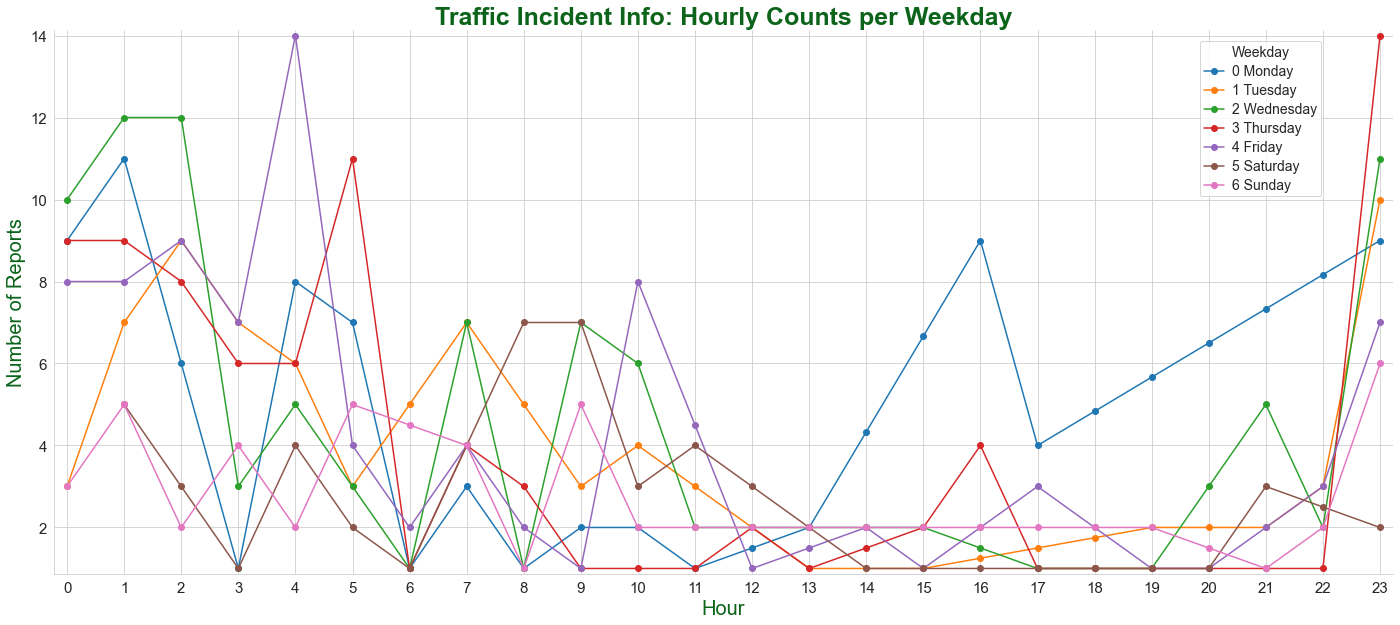

In [8]:
# group by on weekday and hour, then extract the counts as well
week_hour_counts = df.groupby(['weekday', 'hour']).size().reset_index().rename(columns = {0: 'count'})
week_hour_counts = week_hour_counts.pivot(index='hour', columns='weekday', values='count')
week_hour_counts

sns.set_palette(sns.color_palette('tab10'))
sns.set_context({'figure.figsize': (24, 10)})
sns.set_style('whitegrid')

# Plotting the chart
ax = week_hour_counts.interpolate(method='linear').plot(marker='o')

# Setting the chart
ax.set_title('Traffic Incident Info: Hourly Counts per Weekday', color='#0c641b', fontweight='bold', fontsize=25)
ax.set_xlabel('Hour', color='#0c641b', fontsize=20)
ax.set_ylabel('Number of Reports', color='#0c641b', fontsize=20)
ax.tick_params(labelsize=15)
plt.legend(title='Weekday', bbox_to_anchor=[0.95, 0.99], loc='upper right')
plt.setp(ax.get_legend().get_texts(), fontsize=14)
plt.setp(ax.get_legend().get_title(), fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.margins(0.01)

# set tick frequency
ax.xaxis.set_ticks(np.arange(len(week_hour_counts)))

plt.show()

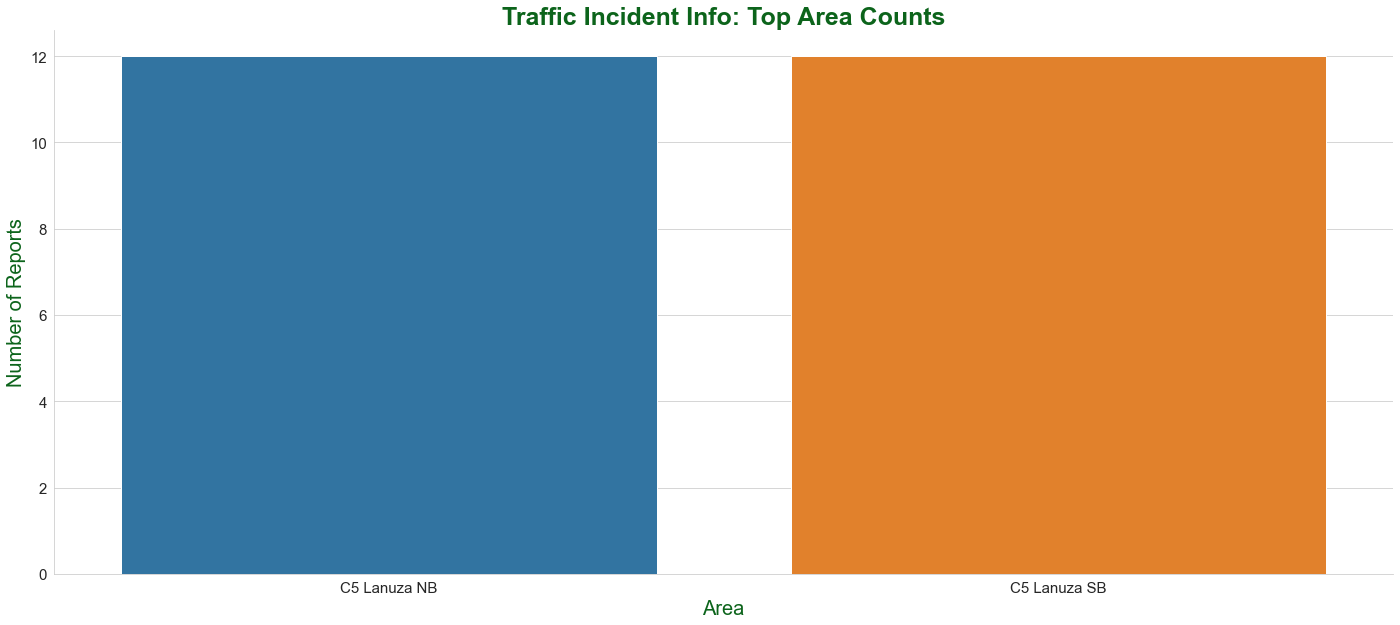

In [9]:
# group by on weekday and hour, then extract the count as well
# but only pick the areas that are greater than the calculated threshold below
loc_counts = df.groupby('area').size().reset_index().rename(columns = {0: 'count'})
# using the midpoint of max and min counts as "threshold" of top areas
loc_thresh = (loc_counts['count'].max() + loc_counts['count'].min()) / 2
loc_counts = loc_counts[loc_counts['count'] > loc_thresh]

sns.set_palette(sns.color_palette())
sns.set_context({'figure.figsize': (24,10)})
sns.set_style('whitegrid')

# Plotting the chart
ax = sns.barplot(x='area', y='count', data=loc_counts)

# Setting the chart
ax.set_title('Traffic Incident Info: Top Area Counts', color='#0c641b', fontweight='bold', fontsize=25)
ax.set_xlabel('Area', color='#0c641b', fontsize=20)
ax.set_ylabel('Number of Reports', color='#0c641b', fontsize=20)
ax.tick_params(labelsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

## **V. Modeling & Evaluation**

For this section, there are a number of possible methods for attack with this nature of data. As mentioned previously, Kreskin et al. (2020) tackled a very similar issue, but using classification and clustering techniques such as **k-order Nearest Neighbourhood and k-Means** to determine the most accident-prone areas around a university's campus.

However, whereas their study tackled the issue through the use of **location**, this project aims to identify issues through **time**, and by using **regression techniques**. More specifically, this project will be making use of degree-2 **Polynomial Regression** ("quadratic regression") through `scikit`, as recommended by Peng et al. (2019) one of the methods in modelling traffic forecasting.

With regards to the variables, four values can be discernably used as or be converted to numerical data for the prediction model: the number of lanes, the day of the week, the hour range, and the road direction. From these, the **independent variables** will be the **year**, the **month**, the **weekday**, the **hour**, the **presence of vehicles such as cars and motorcycles**, the **direction**, and the **number of lanes**. Thus, the **dependent variable** to predict will be the **count of traffic incidents**. After the feature engineering, the dataset must be grouped based on similar features to generate the counts as the dependent variable.

Currently, the column for the specific area is too varied to be able to create any meaningful conversion as some numerical data.

In [10]:
# conversion of columns: lanes, weekday, month, direction

# weekday and month conversion to numbers
df['weekday'] = df['timestamp'].map(lambda a: a.weekday())
df['month'] = df['timestamp'].map(lambda a: a.month)

# direction conversion to numbers
direction_map = {"NB": 1, "SB": 2, "EB": 3, "WB": 4}
df['direct_num'] = df['direction'].map(direction_map)
df['direct_num'] = df['direct_num'].fillna(0)
df['direct_num'] = df['direct_num'].astype(int)

# lanes null conversion to 0
df['lanes'] = df['lanes'].fillna(0)
df['lanes'] = df['lanes'].astype(int)

# grouping all the columns
aggregated = df.groupby(['year', 'month', 'day', 'hour', 'weekday', 'motorcycle', 'car', 'van', 'truck', 'suv', 'direct_num', 'lanes']).size().reset_index().rename(columns = {0: 'count'})
aggregated.describe()

,year,month,day,hour,weekday,motorcycle,car,van,truck,suv,direct_num,lanes,count
count,384.0,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000
mean,2022.0,1.346354,14.445312,8.757812,2.750000,0.445312,0.299479,0.184896,0.135417,0.127604,2.106771,0.994792,1.343750
std,0.0,0.476428,8.791886,7.760191,1.822402,0.497649,0.458627,0.388720,0.342614,0.334084,1.159164,0.191119,0.486435
min,2022.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2022.0,1.000000,7.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
50%,2022.0,1.000000,12.000000,7.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1.000000
75%,2022.0,2.000000,22.250000,15.000000,4.000000,1.000000,1.000000,0.000000,0.000000,0.000000,3.000000,1.000000,2.000000
max,2022.0,2.000000,31.000000,23.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,2.000000,3.000000


In [11]:
# inserting negative rows (zero-count hours)
dates = pd.to_datetime(aggregated[['year', 'month', 'day', 'hour']])
missings = []

# finding all missing hours in the current set
nxt = dates.loc[0]
end_date = dates.loc[len(dates) - 1]
while nxt <= end_date:
    nxt += timedelta(hours=1)
    if nxt not in dates:
        missings.append(nxt)

# recreate the df structure
missings = [{
    'year': i.year,
    'month': i.month,
    'day': i.day,
    'hour': i.hour,
    'weekday': i.weekday(),
    'motorcycle': 0,
    'car': 0,
    'van': 0,
    'truck': 0,
    'suv': 0,
    'direct_num': 0,
    'lanes': 0,
    'count': 0
} for i in missings]
missing_df = pd.DataFrame(missings, columns=['year', 'month', 'day', 'hour', 'weekday', 'motorcycle', 'car', 'van', 'truck', 'suv', 'direct_num', 'lanes', 'count'])

# insert back into aggregard and sort
aggregated = pd.concat([aggregated, missing_df]).sort_values(by=['year', 'month', 'day', 'hour']).reset_index(drop=True)
aggregated.head()

,year,month,day,hour,weekday,motorcycle,car,van,truck,suv,direct_num,lanes,count
0,2022,1,4,13,1,0,0,0,0,0,1,1,1
1,2022,1,4,14,1,0,0,0,0,0,0,0,0
2,2022,1,4,15,1,0,0,0,0,0,0,0,0
3,2022,1,4,16,1,0,0,0,0,0,0,0,0
4,2022,1,4,17,1,0,0,0,0,0,0,0,0


In [12]:
# generating future datestamps
curr_datestamp = pd.to_datetime(aggregated.iloc[-1:][['year', 'month', 'day', 'hour']]).values[0]
curr_datestamp = datetime.utcfromtimestamp(int(curr_datestamp)/1e9)
future = []
future.append(curr_datestamp)

# insert the next 48 hours into the list
for i in range(48):
    curr_datestamp += timedelta(hours=1)
    future.append(curr_datestamp)

# recreate the df structure
# we create a number of assumptions to simplify the generation:
#### number of lanes occupied is 1,
#### a motorcycle and a car were involved in the incident, and
#### the direction is northbound
future = [{
    'year': i.year,
    'month': i.month,
    'day': i.day,
    'hour': i.hour,
    'weekday': i.weekday(),
    'motorcycle': 1,
    'car': 1,
    'van': 0,
    'truck': 0,
    'suv': 0,
    'direct_num': 1,
    'lanes': 1
} for i in future]
future_df = pd.DataFrame(future, columns=['year', 'month', 'day', 'hour', 'weekday', 'motorcycle', 'car', 'van', 'truck', 'suv', 'direct_num', 'lanes'])
future_df.head()

,year,month,day,hour,weekday,motorcycle,car,van,truck,suv,direct_num,lanes
0,2022,2,12,9,5,1,1,0,0,0,1,1
1,2022,2,12,10,5,1,1,0,0,0,1,1
2,2022,2,12,11,5,1,1,0,0,0,1,1
3,2022,2,12,12,5,1,1,0,0,0,1,1
4,2022,2,12,13,5,1,1,0,0,0,1,1


In [13]:
# split the dataset, 80:20
split_size = int(np.floor(len(aggregated) * 0.2))

# splitting set to x and y sets
x_set = aggregated[['year', 'month', 'day', 'weekday', 'hour', 'motorcycle', 'car', 'van', 'truck', 'suv', 'direct_num', 'lanes']]
y_set = aggregated['count']

X_train = x_set[:-split_size].copy()
y_train = y_set[:-split_size].copy()
X_test = x_set[-split_size:].copy()
y_test = y_set[-split_size:].copy()

# examining the dataset before analysis
print(f'training set size: {len(X_train)}; testing set size: {len(X_test)}')

training set size: 1053; testing set size: 263


In [14]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm

# making use of polynomial features, setting to degree 2
poly = PolynomialFeatures(degree=2)
poly_features = poly.fit_transform(x_set)

# training (fitting) and predicting
poly_reg_model = LinearRegression()
poly_reg_model.fit(X_train, y_train)
poly_reg_y_predicted = poly_reg_model.predict(X_test)
poly_reg_y_pred_past = poly_reg_model.predict(X_train)
polt_reg_y_pred_future = poly_reg_model.predict(future_df)

In [15]:
# reconstructing the aggregated REAL and PRED sets, along with the future set
agg_real = aggregated.copy()
agg_pred = x_set.copy()
agg_pred['count'] = pd.concat([y_train, pd.Series(poly_reg_y_predicted)]).reset_index().rename(columns={0: 'count'})['count']
agg_pred_past = x_set.copy()
agg_pred_past['count'] = pd.concat([pd.Series(poly_reg_y_pred_past), pd.Series(poly_reg_y_predicted)]).reset_index().rename(columns={0: 'count'})['count']
agg_pred_future = future_df.copy()
agg_pred_future['count'] = pd.concat([pd.Series(polt_reg_y_pred_future)]).reset_index().rename(columns={0: 'count'})['count']

# get the total counts of the time-series sets to get plots that make sense
agg_real = agg_real.groupby(['year', 'month', 'day', 'hour'])['count'].sum().reset_index().rename(columns = {0: 'sum_count'})
agg_pred = agg_pred.groupby(['year', 'month', 'day', 'hour'])['count'].sum().reset_index().rename(columns = {0: 'sum_count'})
agg_pred_past = agg_pred_past.groupby(['year', 'month', 'day', 'hour'])['count'].sum().reset_index().rename(columns = {0: 'sum_count'})
agg_pred_future = agg_pred_future.groupby(['year', 'month', 'day', 'hour'])['count'].sum().reset_index().rename(columns = {0: 'sum_count'})

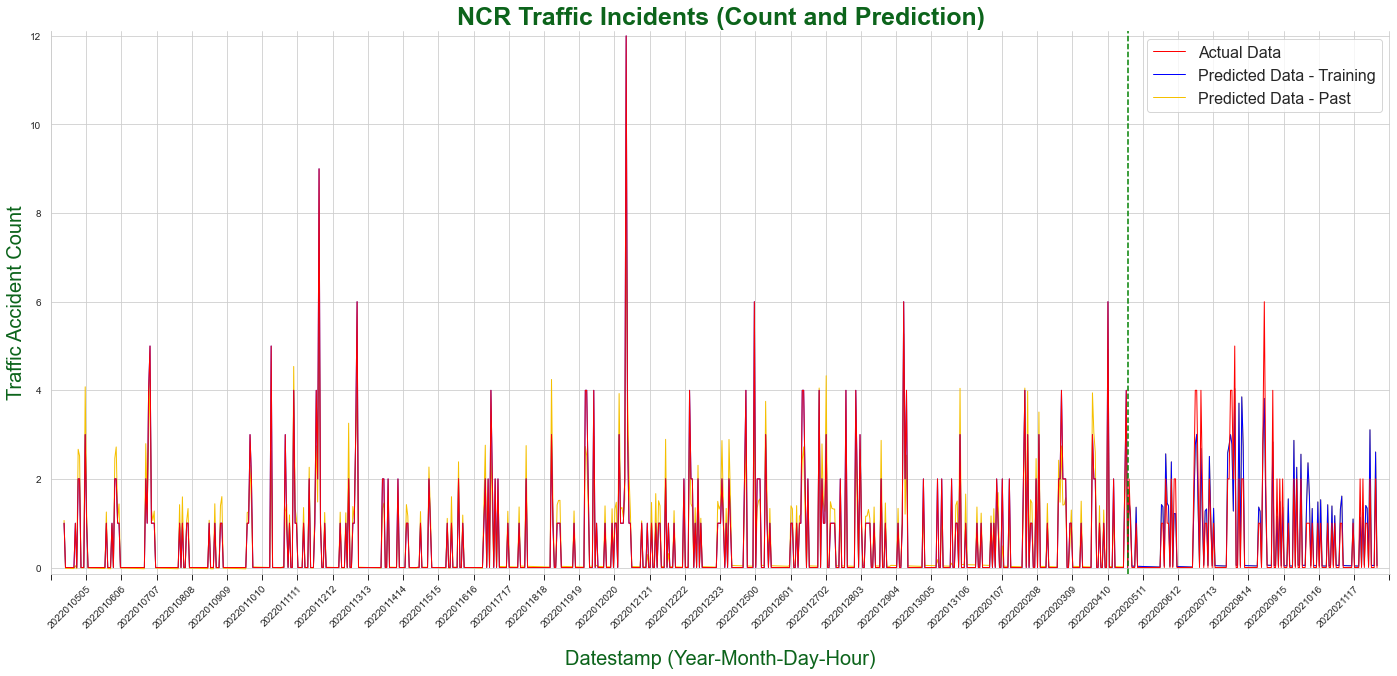

In [16]:
sns.set_palette(sns.color_palette())
sns.set_context({'figure.figsize': (24, 10)})
sns.set_style('whitegrid')

# Plotting the chart
ax = plt.subplot(111)

line_pred_past, = ax.plot(agg_pred_past['year'].astype(str) +
                     agg_pred_past['month'].astype(str).map(lambda x: f'{x:0>2}') +
                     agg_pred_past['day'].astype(str).map(lambda x: f'{x:0>2}') +
                     agg_pred_past['hour'].astype(str).map(lambda x: f'{x:0>2}'), agg_pred_past['count'], c='#F5C000', linewidth=1)
line_pred, = ax.plot(agg_pred['year'].astype(str) +
                     agg_pred['month'].astype(str).map(lambda x: f'{x:0>2}') +
                     agg_pred['day'].astype(str).map(lambda x: f'{x:0>2}') +
                     agg_pred['hour'].astype(str).map(lambda x: f'{x:0>2}'), agg_pred['count'], c='blue', linewidth=1)
line_true, = ax.plot(agg_real['year'].astype(str) +
                     agg_real['month'].astype(str).map(lambda x: f'{x:0>2}') +
                     agg_real['day'].astype(str).map(lambda x: f'{x:0>2}') +
                     agg_real['hour'].astype(str).map(lambda x: f'{x:0>2}'), agg_real['count'], c='red', linewidth=1)

# Setting the chart
ax.set_title('NCR Traffic Incidents (Count and Prediction)', color='#0c641b', fontweight='bold', fontsize=25)
ax.set_xlabel('Datestamp (Year-Month-Day-Hour)', color='#0c641b', fontsize=20, labelpad=20)
ax.set_ylabel('Traffic Accident Count', color='#0c641b', fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.margins(0.01)
ax.tick_params(bottom=True, length=6, width=1)

# legend
ax.legend([line_true, line_pred, line_pred_past], ['Actual Data', 'Predicted Data - Training', 'Predicted Data - Past'],
          fontsize=16,
          loc='upper right')

# set tick frequency
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 25))

# tick rotation
for i in ax.get_xticklabels():
    i.set(horizontalalignment='right')
    i.set_rotation(45)
    i.set_rotation_mode('anchor')

# line where predicted values start
agg_diff = pd.concat([agg_real, agg_pred]).drop_duplicates(keep=False)
ax.axvline(agg_diff.index[0] - 1, ls='--', color='g')
del agg_diff

# plt.savefig('count_preds.png', bbox_inches='tight')
plt.show()

For additional sanity checks and because the dataset used for generating the chart is rather large, two more charts will be generated.

A **slice of the testing set** in comparison with the **model predictions** will be created. Then, because the goal of this project is to also provide traffic predictions for the future, the next chart will also feature **predictions of datestamps outside the collected data** (i.e.: data predicted to be in the future).

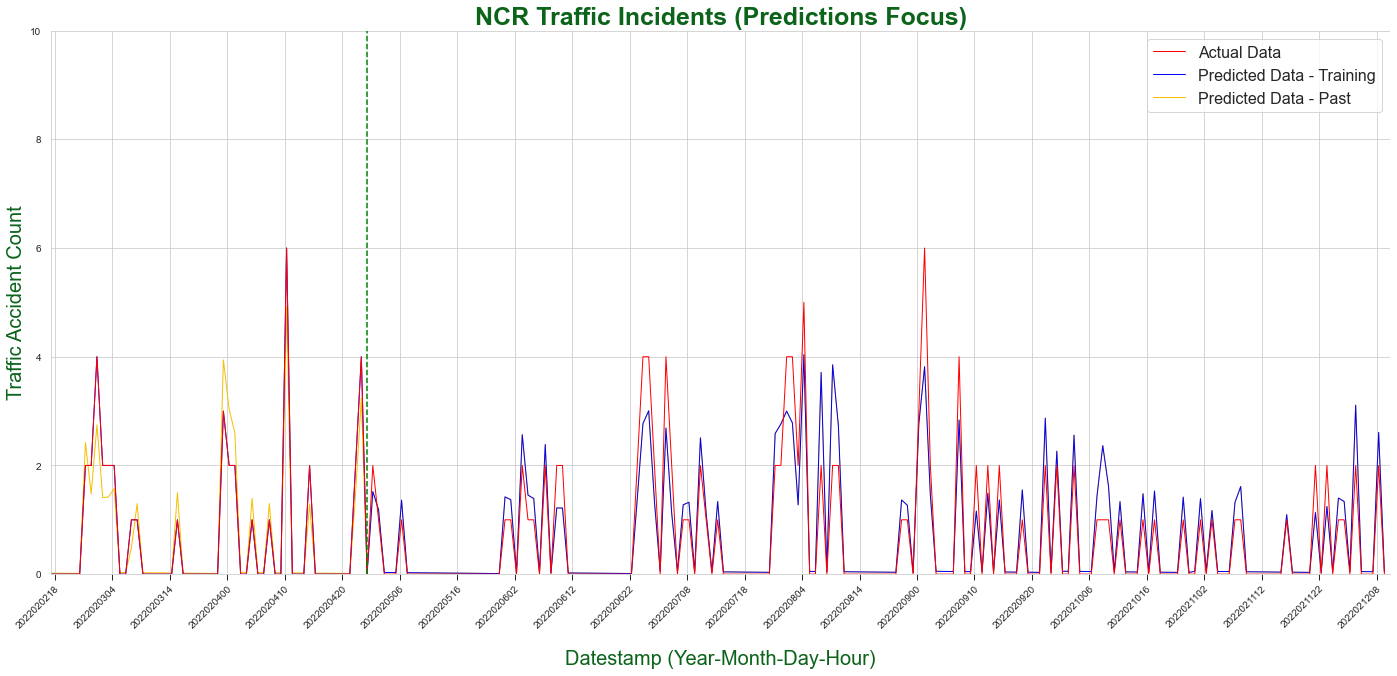

In [17]:
# getting a slice of the data to "zoom in" on a part

# Plotting the chart
ax = plt.subplot(111)

line_pred_past, = ax.plot(agg_pred_past['year'].astype(str) +
                     agg_pred_past['month'].astype(str).map(lambda x: f'{x:0>2}') +
                     agg_pred_past['day'].astype(str).map(lambda x: f'{x:0>2}') +
                     agg_pred_past['hour'].astype(str).map(lambda x: f'{x:0>2}'), agg_pred_past['count'], c='#F5C000', linewidth=1)
line_pred, = ax.plot(agg_pred['year'].astype(str) +
                     agg_pred['month'].astype(str).map(lambda x: f'{x:0>2}') +
                     agg_pred['day'].astype(str).map(lambda x: f'{x:0>2}') +
                     agg_pred['hour'].astype(str).map(lambda x: f'{x:0>2}'), agg_pred['count'], c='blue', linewidth=1)
line_true, = ax.plot(agg_real['year'].astype(str) +
                     agg_real['month'].astype(str).map(lambda x: f'{x:0>2}') +
                     agg_real['day'].astype(str).map(lambda x: f'{x:0>2}') +
                     agg_real['hour'].astype(str).map(lambda x: f'{x:0>2}'), agg_real['count'], c='red', linewidth=1)

# Setting the chart
ax.set_title('NCR Traffic Incidents (Predictions Focus)', color='#0c641b', fontweight='bold', fontsize=25)
ax.set_xlabel('Datestamp (Year-Month-Day-Hour)', color='#0c641b', fontsize=20, labelpad=20)
ax.set_ylabel('Traffic Accident Count', color='#0c641b', fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.margins(0.01)
ax.tick_params(bottom=True, length=6, width=1)

# legend
ax.legend([line_true, line_pred, line_pred_past], ['Actual Data', 'Predicted Data - Training', 'Predicted Data - Past'],
          fontsize=16,
          loc='upper right')

# set tick frequency
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 10))

# tick rotation
for i in ax.get_xticklabels():
    i.set(horizontalalignment='right')
    i.set_rotation(45)
    i.set_rotation_mode('anchor')

# line where predicted values start
agg_diff = pd.concat([agg_real, agg_pred]).drop_duplicates(keep=False)
ax.axvline(agg_diff.index[0] - 1, ls='--', color='g')
del agg_diff

plt.axis([700, len(agg_pred), 0, 10])
plt.show()

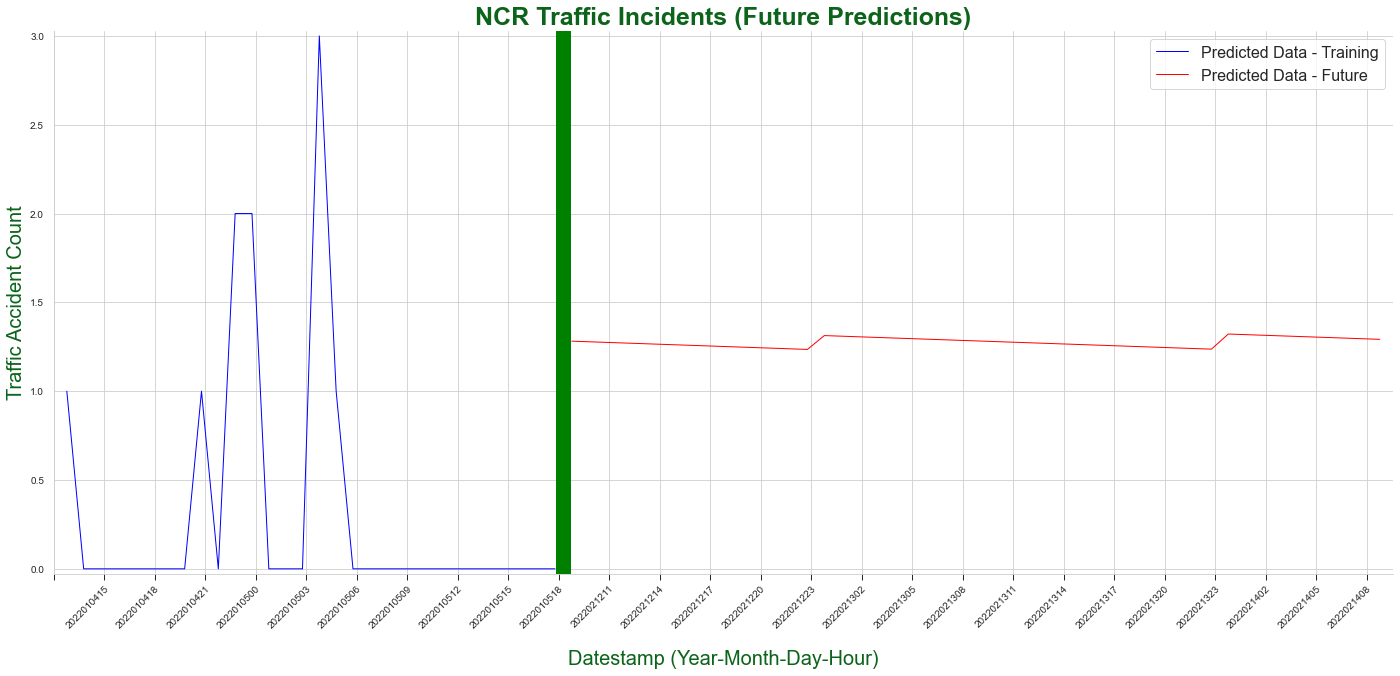

In [18]:
# predicting the future now

# Plotting the chart
ax = plt.subplot(111)

# last 30 prediction dates from testing set
agg_pred_slice = agg_pred.iloc[:30]
line_pred, = ax.plot(agg_pred_slice['year'].astype(str) +
                     agg_pred_slice['month'].astype(str).map(lambda x: f'{x:0>2}') +
                     agg_pred_slice['day'].astype(str).map(lambda x: f'{x:0>2}') +
                     agg_pred_slice['hour'].astype(str).map(lambda x: f'{x:0>2}'), agg_pred_slice['count'], c='blue', linewidth=1)
line_pred_future, = ax.plot(agg_pred_future['year'].astype(str) +
                     agg_pred_future['month'].astype(str).map(lambda x: f'{x:0>2}') +
                     agg_pred_future['day'].astype(str).map(lambda x: f'{x:0>2}') +
                     agg_pred_future['hour'].astype(str).map(lambda x: f'{x:0>2}'), agg_pred_future['count'], c='red', linewidth=1)

# Setting the chart
ax.set_title('NCR Traffic Incidents (Future Predictions)', color='#0c641b', fontweight='bold', fontsize=25)
ax.set_xlabel('Datestamp (Year-Month-Day-Hour)', color='#0c641b', fontsize=20, labelpad=20)
ax.set_ylabel('Traffic Accident Count', color='#0c641b', fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.margins(0.01)
ax.tick_params(bottom=True, length=6, width=1)

# set tick frequency
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 3))

# tick rotation
for i in ax.get_xticklabels():
    i.set(horizontalalignment='right')
    i.set_rotation(45)
    i.set_rotation_mode('anchor')

# legend
ax.legend([line_pred, line_pred_future], ['Predicted Data - Training', 'Predicted Data - Future'],
          fontsize=16,
          loc='upper right')

ax.axvline(len(agg_pred_slice) - 0.5, ls='-', color='g', lw=15)

plt.show()

We will also be evaluating the performance of the prediction model using the **Root Mean Squared Error** and the **R^2** value. Additionally, we will use `statsmodel` to generate a summary that also contains the **p-value** (significance) of the variables using **Ordinary Least Squares**.

> R-squared is the measurement of how much of the independent variable is explained by changes in our dependent variables.  
> A low `std error` compared to a high coefficient produces a high t statistic, which signifies a high significance for your coefficient.  
> `P>|t|` is one of the most important statistics in the summary. It uses the t statistic to produce the p value, a measurement of how likely your coefficient is measured through our model by chance.

In [19]:
# RMSE
poly_reg_rmse = np.sqrt(mean_squared_error(y_test, poly_reg_y_predicted))
print(f"Root Mean Squared Error:", poly_reg_rmse)

# MAE
poly_reg_mae = mean_absolute_error(y_test, poly_reg_y_predicted)
print(f"Mean Absolute Error:", poly_reg_mae)

# R^2 & p-value
X_test_stat = sm.add_constant(X_test)
stats_model = sm.OLS(y_test, X_test_stat)
print(stats_model.fit().summary())

Root Mean Squared Error: 0.3187880002970716
Mean Absolute Error: 0.18251874823968772
                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     129.9
Date:                Wed, 02 Mar 2022   Prob (F-statistic):           1.98e-93
Time:                        22:16:42   Log-Likelihood:                -38.409
No. Observations:                 263   AIC:                             98.82
Df Residuals:                     252   BIC:                             138.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

## **VI. Results and Conclusion**

According to the final plot of the predicted values, the model predicted that the the incidents are most likely to occur around the neighbourhood of midnight to noon, or mostly in the early to late morning, then spikes again when approaching midnight near the end of the day.

Also, judging by the scores of the model, it seems that the Regression model performed fairly well, considering the RMSE value is around the same area as well as the rest of the values. Additionally, given that the R^2 value is 0.838, there is some crediblity to the "explainability" between the dependent and independent variables. Looking at the variables individually as well, their p-values indicate that the variables to time may have helped with the predictions compared to, say, the variables on the vehicle presence. Definitely, this study and its accompanying model are not perfect. For starters, the trendline for the future prediction does not look natural, so perhaps a second look at the prediction model is needed.

On the other hand, there are a number of features that could still have potential to have influence over the prediction model's decision-making. This means that there are still avenues where additional processing could be done. For example, despite making use of the **presence of specific vehicles** as suggested by Wang et al. (2018), there is still utility in using the `area` column to retrieve the **general area of the incident** (i.e., which major road, in a categorical sense). Extending this as well to other kinds of tweets posted by the MMDA where they include traffic updates to resolutions of incidents and road obstruction could also give more insights to the duration of incidents.

## **VII. References**

-    Beltran, B. B. (2021). Where we are now on road safety. https://www.bworldonline.com/where-we-are-now-on-road-safety/
-    Keskin, F., Yenilmez, F., Çolak, M., Yavuzer, O., Düzgün, H. U. (2011). Analysis of traffic incidents in METU campus. Procedia Social and Behavioral Sciences, 19, 61–70.
-    McAleer, T. (2020). Interpreting Linear Regression Through statsmodels .summary(). https://medium.com/swlh/interpreting-linear-regression-through-statsmodels-summary-4796d359035a
-    Peng, H., Klepp, N., Toutiaee, M., Arpinar, I. B., Miller, J. A. (2019). Knowledge and Situation-Aware Vehicle Traffic Forecasting. 2019 IEEE International Conference on Big Data (Big Data), 3803 - 3812.
-    Wang, S., Li, R., Guo, M. (2018). Application of Nonparametric Regression in Predicting Traffic Incident Duration. Transport, 33(1), 22–31.

In [ ]:
# quick exporting (optional step)

df_export = pd.DataFrame(processed, columns=['raw_time', 'text_content'])
df_export['text_content'] = df_export['text_content'].map(lambda a: a.split('\n')[4].replace('  ', ' '))
df_export.to_csv('mmda.csv', index=False)
del df_export

In [2]:
# quick importing (optional step)

df_import = pd.read_csv('mmda.csv')
processed = df_import.to_dict('records')
del df_import